### Overview

The AMBRS tools facilitate intercomparison of aerosol box models. The core coponents include (1) the CMake-based *ambuilder* for consistent model building, (2) the Python-based *amdriver* for automated generation of unified numerical experiments, and (3) the Python-based *pyparticle* package for standardization of model output and downstream analysis.

This notebook describes the steps to build, run, and analyze the AMBRS models.

### Step 1: Build supported models via AMBuilder

Build all box models via [AMbuilder](https://github.com/AMBRS-project/ambuilder)

Install additional AMBRS dependencies via:
```
pip install -r requirements.txt
```

### Step 2: Run comparable simulation experiments with the AMBRS driver  

In [ ]:
# -----------------------------------------------------------
# Import modules
# -----------------------------------------------------------
import os
import logging
from math import log10
from pathlib import Path

import numpy as np
import scipy.stats as stats

import ambrs
from pathlib import Path

# -----------------------------------------------------------
# Configure simualtions
# -----------------------------------------------------------

n = 5        # number of ensemble members
n_part = 1000  # PartMC particles per run

dt = 60      # timestep [s]
nstep = 60   # 60 min run

p0 = 101325  # reference pressure [Pa]
h0 = 500     # reference height [m]

# -----------------------------------------------------------
# Make directories for simulation output
# -----------------------------------------------------------
ensemble_name = str(int(dt*nstep/60)) + "min_" + str(n_part) + "particles"
repo_root = Path.cwd().resolve()
root_dir =  repo_root / "runs" 
ensemble_dir =  root_dir / ensemble_name
partmc_dir = os.path.join(ensemble_dir, "partmc_runs")
mam4_dir = os.path.join(ensemble_dir, "mam4_runs")

for d in [root_dir, ensemble_dir, partmc_dir, mam4_dir]:
    os.makedirs(d, exist_ok=True)


# -----------------------------------------------------------
# Define species
# -----------------------------------------------------------
so4 = ambrs.AerosolSpecies("SO4", molar_mass=96., density=1800., hygroscopicity=0.65)
nh4 = ambrs.AerosolSpecies("NH4", molar_mass=18., density=1800., hygroscopicity=0.65)
pom = ambrs.AerosolSpecies("OC", molar_mass=12.01, density=1000., hygroscopicity=0.001)
soa = ambrs.AerosolSpecies("MSA", molar_mass=40., density=2600., hygroscopicity=0.53)
bc  = ambrs.AerosolSpecies("BC",  molar_mass=12.01, density=1800., hygroscopicity=0.)
dst = ambrs.AerosolSpecies("OIN", molar_mass=135.065, density=2600., hygroscopicity=0.1)
na  = ambrs.AerosolSpecies("Na",  molar_mass=23., density=2200., hygroscopicity=0.53)
cl  = ambrs.AerosolSpecies("Cl",  molar_mass=35.5, density=2200., hygroscopicity=0.53)
ncl = na
h2o = ambrs.AerosolSpecies("H2O", molar_mass=18., density=1000., ions_in_soln=1)

so2   = ambrs.GasSpecies("SO2", molar_mass=64.07)
h2so4 = ambrs.GasSpecies("H2SO4", molar_mass=98.079)

# -----------------------------------------------------------
# Define aerosol processes
# -----------------------------------------------------------
processes = ambrs.AerosolProcesses(
    coagulation=True,
    condensation=True,
    do_camp_chem=False,
)

# -----------------------------------------------------------
# Ensemble specification
# -----------------------------------------------------------

# MAM4 GMDs and GSDs taken from MAM_box_model/box_model_utils/rad_constituents.f90
spec = ambrs.EnsembleSpecification(
    name=ensemble_name,
    aerosols=(so4, nh4, pom, soa, bc, dst, ncl, h2o),
    gases=(so2, h2so4),
    size=ambrs.AerosolModalSizeDistribution(modes=[
        ambrs.AerosolModeDistribution(
            name="accumulation",
            species=[so4, pom, soa, bc, dst, ncl],
            # number=stats.uniform(1e8, 1e10, loc=0, scale=1),
            number=stats.uniform(1e7, 1e10),
            geom_mean_diam=stats.rv_discrete(values=([1.1e-7], [1.])),
            log10_geom_std_dev=log10(1.8), 
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # POM 
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # BC 
                stats.rv_discrete(values=([0.], [1.])),  # DST
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="aitken",
            species=[so4, soa, ncl],
            number=stats.uniform(1e7, 1e11),
            # number=stats.loguniform(1e7, 1e11, loc=0, scale=1),
            # number=stats.rv_discrete(values=([0.], [1.])), # used to zero out all but one mode for debugging
            geom_mean_diam=stats.rv_discrete(values=([2.6e-8], [1.])),
            log10_geom_std_dev=log10(1.6), 
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="coarse",
            species=[dst, ncl, so4, bc, pom, soa],
            number=stats.uniform(1e5, 1e7),
            # number=stats.loguniform(1e5, 1e7, loc=0, scale=1),
            # number=stats.rv_discrete(values=([0.], [1.])), # used to zero out all but one mode for debugging
            geom_mean_diam=stats.rv_discrete(values=([2e-6], [1.])),
            log10_geom_std_dev=log10(1.6), # 1.6 s correct (and 1.8 is incorrect) (I think)
            mass_fractions=[
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])), # POM
                stats.rv_discrete(values=([0.], [1.])),
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="primary carbon",
            species=[pom, bc],
            number=stats.rv_discrete(values=([0.], [1.])), # primary carbon mode zeroed out for now
            geom_mean_diam=stats.loguniform(1e-8, 5e-8),
            log10_geom_std_dev=log10(1.8),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # POM
                stats.rv_discrete(values=([0.], [1.])),  # BC
            ],
        ),
    ]),
    # concentrations specified in mol/mol-air
    gas_concs=tuple([stats.rv_discrete(values=([0.], [1.])),stats.uniform(1e-10, 1e-8)]), # set SO2 concentration to zero, H2SO4 only
    # gas_concs=tuple([stats.uniform(0, 1e-8), stats.rv_discrete(values=([0.], [1.]))]), # set SO2 concentration to zero, H2SO4 only
    flux=stats.uniform(1e-11, 1e-8), # not doing anything
    relative_humidity=stats.rv_discrete(values=([0.], [1.])),
    temperature=stats.uniform(240, 70),
    pressure=p0,
    height=h0,
)

# -----------------------------------------------------------
# Create ensemble
# -----------------------------------------------------------
ensemble = ambrs.lhs(specification=spec, n=n)
scenario_names = [str(ii).zfill(1) for ii in range(1, len(ensemble.flux)+1)]


# -----------------------------------------------------------
# Run MAM4
# -----------------------------------------------------------
mam4 = ambrs.mam4.AerosolModel(processes=processes)
mam4_inputs = mam4.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
mam4_runner = ambrs.PoolRunner(
    model=mam4,
    executable="mam4",
    root=mam4_dir,
    num_processes=1,
)
mam4_runner.run(mam4_inputs)

# -----------------------------------------------------------
# Run PartMC
# -----------------------------------------------------------
partmc = ambrs.partmc.AerosolModel(
    processes=processes,
    run_type="particle",
    n_part=n_part,
    n_repeat=1,
)
partmc_inputs = partmc.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
partmc_runner = ambrs.PoolRunner(
    model=partmc,
    executable="partmc",
    root=partmc_dir,
    num_processes=1,
)
partmc_runner.run(partmc_inputs)


mam4: one or more existing scenario directories found. Overwriting contents...
partmc: one or more existing scenario directories found. Overwriting contents...


### Step 3: Analyze and vizualize model output with pyparticle    

/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/ambrs/ambrs/viz.py:217: SyntaxWarning: invalid escape sequence '\m'
  xvarlab = 'diameter [$\mu$m]'


ValueError: array must not contain infs or NaNs

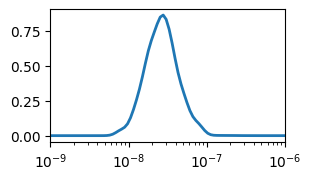

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec as mgs  # <-- for GridSpecFromSubplotSpec

# scenarios = ["1","2","3","4","5"]   # rows

fig = plt.figure(constrained_layout=True, figsize=(12, 7))

scenario_names = None
if scenario_names == None:
    n_scenarios = ensemble.__len__()
else:
    n_scnearios = len(scenario_names)
# Make a 4-column OUTER grid: [DSD init | DSD after 30 min | CCN  after 30 min | SCAT  after 30 min]

outer = fig.add_gridspec(
    nrows=n_scenarios, ncols=4, 
    hspace=0.1, wspace=0.6
)

# Make CHILD grids for each block using GridSpecFromSubplotSpec
gs_dsd_init  = mgs.GridSpecFromSubplotSpec(n_scenarios, 1, subplot_spec=outer[:, 0])
gs_dsd  = mgs.GridSpecFromSubplotSpec(n_scenarios, 1, subplot_spec=outer[:, 1])
gs_ccn  = mgs.GridSpecFromSubplotSpec(n_scenarios, 1,              subplot_spec=outer[:, 2])
gs_scat = mgs.GridSpecFromSubplotSpec(n_scenarios, 1,              subplot_spec=outer[:, 3])

final_timestep = 31
# ---- render the left block (dN/dlnD at initialization)
ambrs.viz.render_dNdlnD_grid(
    gs_dsd_init,
    ensemble=ensemble,
    scenario_names=scenario_names,
    timesteps=[1],          # 2 columns on the left
    partmc_dir=partmc_dir,
    mam4_dir=mam4_dir,
    D_range=(2e-9, 5e-7),
    N_bins=1000,
    normalize=True,
    method="kde",
    legend_loc=None
)

# ---- render the second block (dN/dlnD after 30 min)
ambrs.viz.render_dNdlnD_grid(
    gs_dsd,
    ensemble=ensemble,
    scenario_names=scenario_names,
    timesteps=[final_timestep],          # 2 columns on the left
    partmc_dir=partmc_dir,
    mam4_dir=mam4_dir,
    D_range=(2e-9, 5e-7),
    N_bins=1000,
    normalize=True,
    method="kde",
    legend_loc=None,
    sharey=False,
)
all_dsd_axes = fig.axes
y_max = max([ax.get_ylim()[1] for ax in all_dsd_axes])
for ax in all_dsd_axes:
    ax.set_ylim(0, y_max)

# # ---- render the third block (CCN fraction after 30 min)
ambrs.viz.render_frac_ccn_grid(gs_ccn, #fig=fig, 
                        ensemble=ensemble, scenario_names=scenario_names,
                        timesteps=[final_timestep], partmc_dir=partmc_dir, mam4_dir=mam4_dir,
                        legend_loc=None,)
all_axes = fig.axes
for ax in all_axes[-n_scenarios:]:
    ax.set_ylim(0, 1.0)

# ---- render the fourth block (scattering cross section after 30 min)
ambrs.viz.render_bscat_grid(gs_scat, #fig=fig, 
                     ensemble=ensemble, scenario_names=scenario_names,
                     timesteps=[final_timestep], partmc_dir=partmc_dir, mam4_dir=mam4_dir,
                    legend_loc=None)

all_axes = fig.axes
y_max = max([ax.get_ylim()[1] for ax in all_axes[-n_scenarios:]])
cols = ambrs.viz._scenario_colors(n_rows=n_scenarios)
for ii,ax in enumerate(all_axes[-n_scenarios:]):
    # ax.set_ylim(0, y_max)
    ambrs.viz._add_row_label(ax, 'scenario ' + str(ii+1), color=cols[ii])

plt.savefig('ensemble_summary.png', dpi=1000)
plt.show()

